# Анализ данных аренды недвижимости в Москве

В этом ноутбуке мы проведём **разведочный анализ данных (EDA)** и визуализацию признаков, собранных из объявлений аренды квартир в Москве.

На основании полученного датасета, обогащённого географическими координатами, расстояниями до центра города и станций метро, а также признаками доступности объектов инфраструктуры (парки, школы, магазины, аптеки, клиники), мы решим следующие задачи:

---

## Цели ноутбука:

- Исследовать распределения ключевых признаков: площадь, цена, этаж, количество комнат и др.
- Построить геовизуализации и графики зависимости цены от расположения объекта.
- Проанализировать влияние инфраструктурных факторов на стоимость аренды.
- Выявить и **удалить выбросы**, мешающие корректному обучению моделей.
- Сделать **выводы**, полезные для построения модели оценки справедливой аренды.

---


# Импорты основных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Геообработка
import geopandas as gpd
from shapely.geometry import Point

# Работа с расстояниями
from geopy.distance import geodesic

# Общие настройки визуализации
plt.style.use("dark_background")
sns.set(style="darkgrid", palette="muted", font_scale=1.1)

## Распределение цены аренды (`price_per_month`)

Целевая переменная `price_per_month` отражает фактическую месячную стоимость аренды квартиры. Анализ распределения этого признака помогает:

- понять, какие значения наиболее частотны;
- выявить влияние дорогих (элитных) квартир на общую статистику;
- оценить необходимость логарифмирования;
- сформировать правила для фильтрации выбросов.

Ниже представлены статистика и графики распределения цен в рублях.

___

In [2]:
df = pd.read_csv("cian_rent_Moscow_with_poi.csv")

# Общая информация о целевой переменной
df["price_per_month"].describe()

count    1.510200e+04
mean     1.292591e+05
std      1.112172e+05
min      1.500000e+04
25%      6.000000e+04
50%      9.000000e+04
75%      1.490000e+05
max      1.100000e+06
Name: price_per_month, dtype: float64

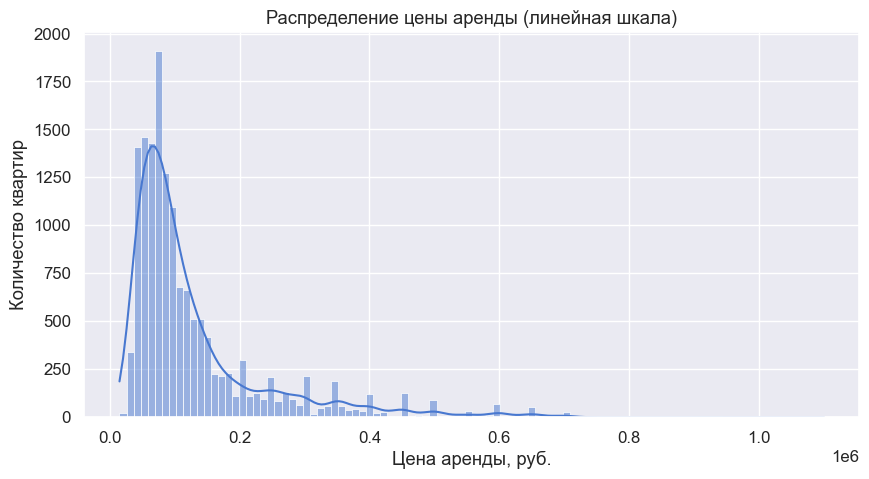

In [3]:
# Гистограмма в линейной шкале
plt.figure(figsize=(10, 5))
sns.histplot(df["price_per_month"], bins=100, kde=True)
plt.title("Распределение цены аренды (линейная шкала)")
plt.xlabel("Цена аренды, руб.")
plt.ylabel("Количество квартир")
plt.grid(True)
plt.show()

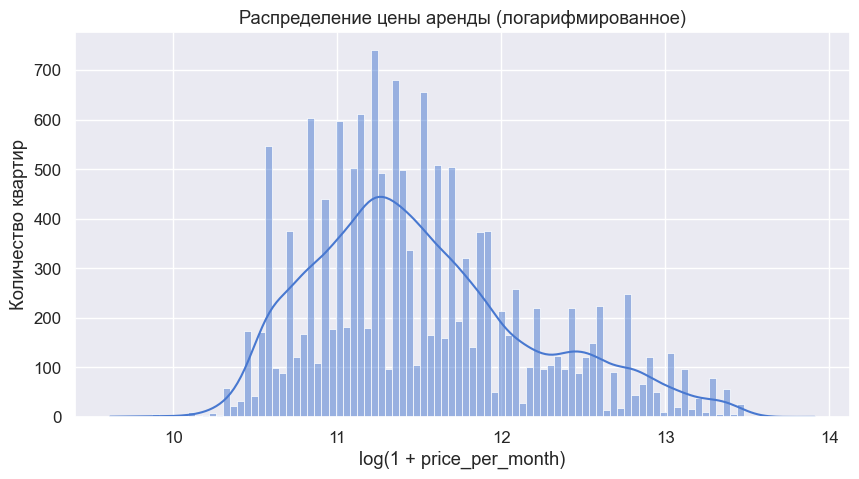

In [4]:
# Гистограмма с логарифмированием
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df["price_per_month"]), bins=100, kde=True)
plt.title("Распределение цены аренды (логарифмированное)")
plt.xlabel("log(1 + price_per_month)")
plt.ylabel("Количество квартир")
plt.grid(True)
plt.show()

### Выводы по `price_per_month`

- Распределение аренды имеет ожидаемое смещение вправо: большинство квартир стоят от **60 000 до 150 000 ₽**.
- **Медианная цена** — **90 000 ₽**, **средняя** — **~129 000 ₽**. Наличие высоких цен влияет на среднее.
- **Максимум — 1 100 000 ₽**, но выбросами это не является — эти объекты входят в премиум-сегмент.
- Логарифмированное распределение близко к нормальному и может быть использовано при построении моделей.

___


## Распределение площади квартиры (`total_meters`)

Площадь — один из базовых факторов ценообразования на рынке аренды. Анализ признака `total_meters` позволяет:

- определить типичный размер квартиры;
- выявить неадекватно малые или чрезмерно большие значения;
- оценить необходимость логарифмирования или фильтрации;
- использовать этот признак напрямую или в виде производной величины (например, цена за квадратный метр).

Ниже приведены распределение площади и базовая статистика.

___

In [5]:
# Статистика по площади
df["total_meters"].describe()

count    15102.000000
mean        61.552349
std         37.454406
min          0.280000
25%         38.200000
50%         52.000000
75%         72.000000
max        548.000000
Name: total_meters, dtype: float64

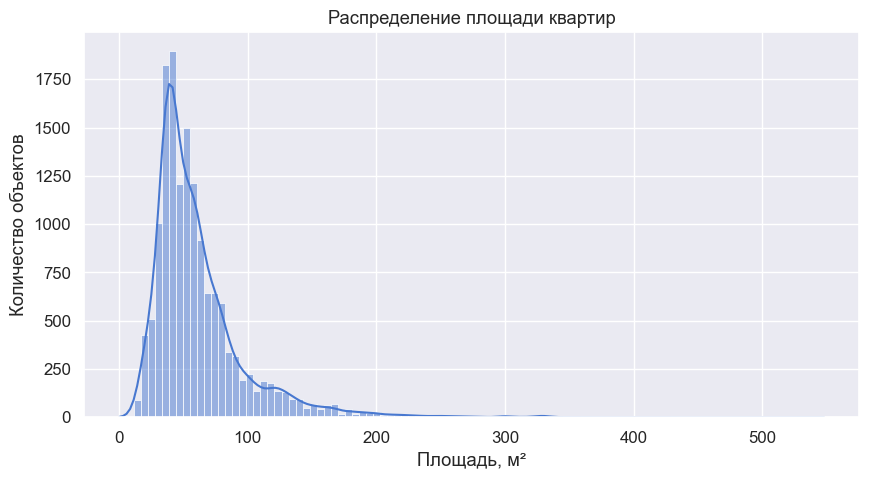

In [6]:
# Распределение площади
plt.figure(figsize=(10, 5))
sns.histplot(df["total_meters"], bins=100, kde=True)
plt.title("Распределение площади квартир")
plt.xlabel("Площадь, м²")
plt.ylabel("Количество объектов")
plt.grid(True)
plt.show()

### Выводы по `total_meters`

- Большинство квартир имеют площадь в пределах **38–72 м²** (межквартильный диапазон).
- **Медианная площадь** — 52 м², **средняя** — 61.6 м², что говорит о наличии более крупных квартир.
- Присутствуют объекты с площадью свыше **300 м²**, максимум — **548 м²**.
- **Распределение скошено вправо**, как и ожидалось: преобладают стандартные квартиры, но есть и крупногабаритные.

___

## Распределение количества комнат (`rooms_count`)

Количество комнат — важный категориально-дискретный признак, определяющий тип жилья: от студий до многокомнатных квартир. Анализ распределения помогает:

- понять, какие форматы квартир преобладают на рынке;
- выявить редкие/аномальные случаи (например, -1 комнат или более 6);
- оценить, нужно ли группировать значения при обучении модели.

___

In [7]:
# Статистика по количеству комнат
df["rooms_count"].describe()

count    15102.000000
mean         1.899550
std          1.047277
min         -1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms_count, dtype: float64

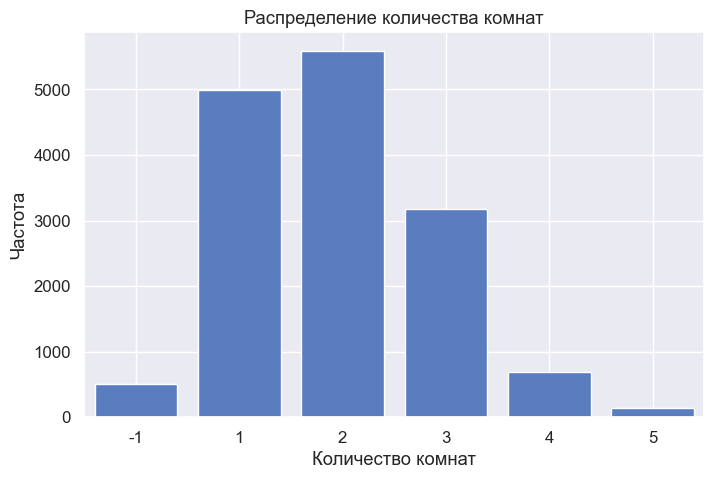

In [8]:
# Распределение количества комнат
plt.figure(figsize=(8, 5))
sns.countplot(x="rooms_count", data=df)
plt.title("Распределение количества комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

In [9]:
df["rooms_count"] = df["rooms_count"].replace(-1, 0)

### Выводы по `rooms_count`

- Признак успешно очищен: студии, ранее обозначенные как `-1`, заменены на `0`.
- Наиболее распространённые типы жилья: **2-комнатные** и **1-комнатные** квартиры.
- Студии (0 комнат) составляют меньшую, но значимую долю выборки.
- Квартиры с 4 и 5 комнатами встречаются редко.
- Значения адекватны, выбросов или аномалий после замены — нет. Признак готов к использованию в модели.

___

## Этаж и этажность (`floor` и `floors_count`)

Признаки `floor` и `floors_count` отражают расположение квартиры и общую высотность дома. Их анализ позволяет:

- выявить распространённые этажи и типовые этажности;
- обнаружить аномалии (например, здания с 200 этажами);
- понять, какие значения преобладают на рынке;

___


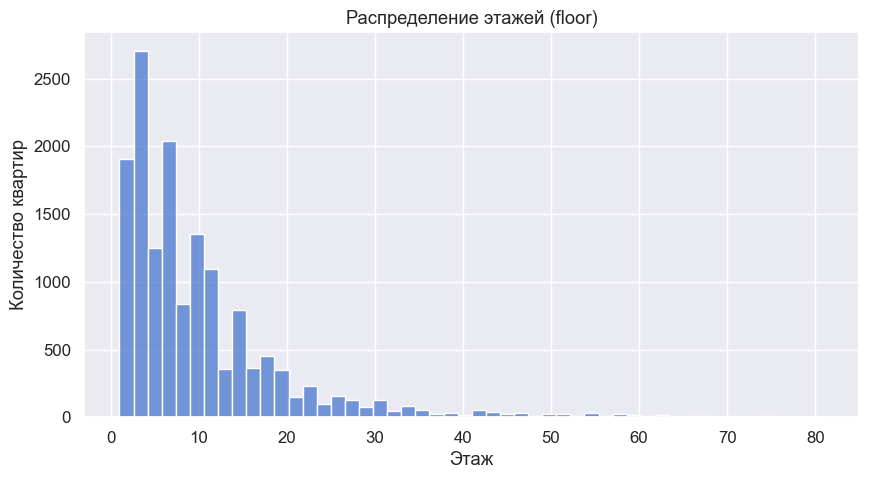

In [10]:
# Распределение этажей
plt.figure(figsize=(10, 5))
sns.histplot(df["floor"], bins=50, kde=False)
plt.title("Распределение этажей (floor)")
plt.xlabel("Этаж")
plt.ylabel("Количество квартир")
plt.grid(True)
plt.show()

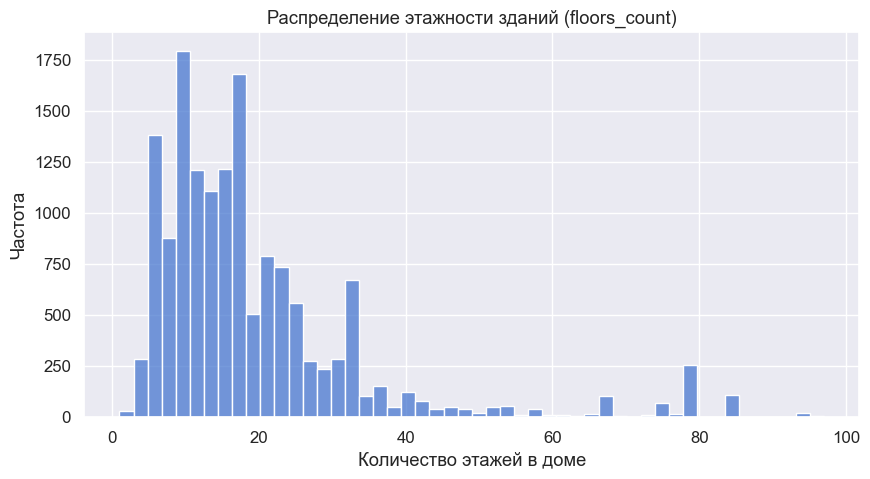

In [11]:
# Распределение этажности зданий
plt.figure(figsize=(10, 5))
sns.histplot(df["floors_count"], bins=50, kde=False)
plt.title("Распределение этажности зданий (floors_count)")
plt.xlabel("Количество этажей в доме")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

### Выводы по `floor` и `floors_count`

- Большинство квартир расположены на **1–20 этажах**, пик — на этажах 3–7.
- Присутствуют объекты выше 50-го этажа, максимум — 95. 
- Распределение этажности домов (`floors_count`) показывает, что **типовая застройка — 8–25 этажей**.
- Есть здания с этажностью выше 70 — скорее всего, современные высотки. 

___


## Геораспределение объектов аренды по координатам

Признаки `lat` и `lon` позволяют отобразить квартиры на карте и визуально оценить:

- охват по всей территории Москвы и ближайших округов (включая Новую Москву и Зеленоград);
- плотность распределения арендных объектов;
- возможные ошибки геокодирования (например, точки вне МСК);
- потенциальные «пустоты» или дисбаланс между районами.

Ниже представлена визуализация геопозиций всех объектов аренды.

___

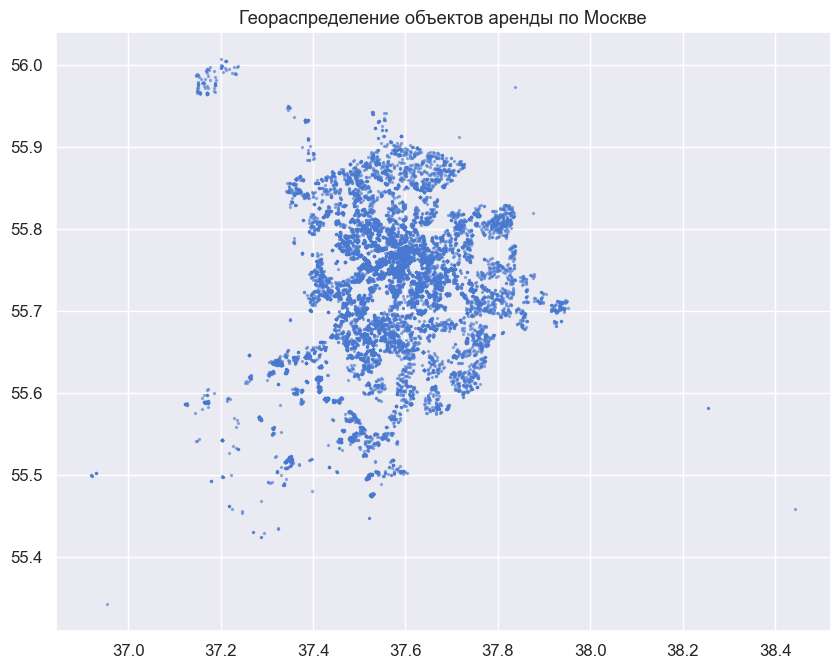

In [12]:
# Преобразуем в GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

# Убираем явно ошибочные координаты
gdf = gdf[(gdf["lat"] > 54) & (gdf["lat"] < 56.5) & (gdf["lon"] > 36) & (gdf["lon"] < 39)]

# Построим карту
ax = gdf.plot(figsize=(10, 10), alpha=0.5, markersize=2)
plt.title("Геораспределение объектов аренды по Москве")
plt.show()

In [13]:
# Фильтрация по границам Москвы
df = df[
    (df["lat"] >= 55.2) & (df["lat"] <= 56.1) &
    (df["lon"] >= 36.8) & (df["lon"] <= 38.1)
]

### Выводы по координатам (`lat`, `lon`)

- Большинство объектов находятся в пределах **старой Москвы**, особенно в центральных и прилегающих районах.
- Значительное количество квартир также расположено в **Новой Москве** (юго-запад) и **Зеленограде** (северо-запад).
- **Единичные точки за пределами Москвы** присутствуют — вероятно, это ошибки геокодирования или пограничные зоны.
- Визуализация подтверждает, что охват геоданных хороший и позволяет анализировать как центр, так и периферию.
- Удаление точек с некорректными координатами уже выполнено по диапазонам.

___


## Анализ расстояния до центра и метро (`dist_to_center_km`, `dist_to_metro_km`)

Признаки `dist_to_center_km` и `dist_to_metro_km` — ключевые географические показатели, напрямую влияющие на стоимость аренды.

Анализ этих признаков позволяет:
- оценить охват выборки по удалённости от центра;
- выявить проблемы в данных (аномалии вроде 1000 км до метро);
- визуализировать взаимосвязь между ценой и локацией;
- использовать эти признаки в модели как сильные числовые регрессоры.

Ниже представлены гистограммы распределений и scatter-графики зависимости от цены.

___

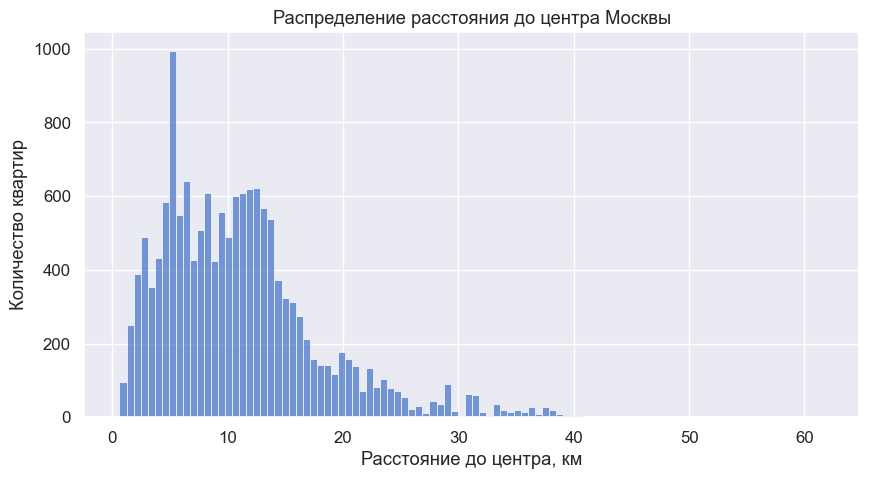

In [14]:
# Гистограмма расстояния до центра
plt.figure(figsize=(10, 5))
sns.histplot(df["dist_to_center_km"], bins=100)
plt.title("Распределение расстояния до центра Москвы")
plt.xlabel("Расстояние до центра, км")
plt.ylabel("Количество квартир")
plt.grid(True)
plt.show()

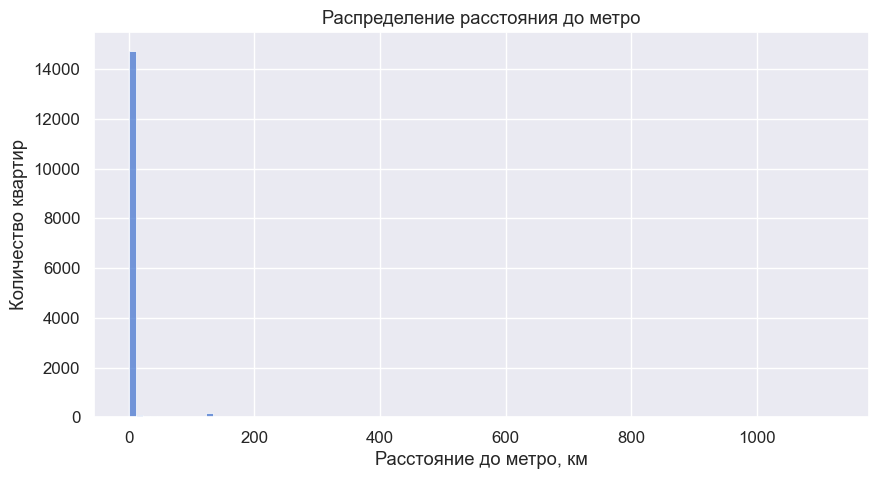

In [15]:
# Гистограмма расстояния до метро
plt.figure(figsize=(10, 5))
sns.histplot(df["dist_to_metro_km"], bins=100)
plt.title("Распределение расстояния до метро")
plt.xlabel("Расстояние до метро, км")
plt.ylabel("Количество квартир")
plt.grid(True)
plt.show()

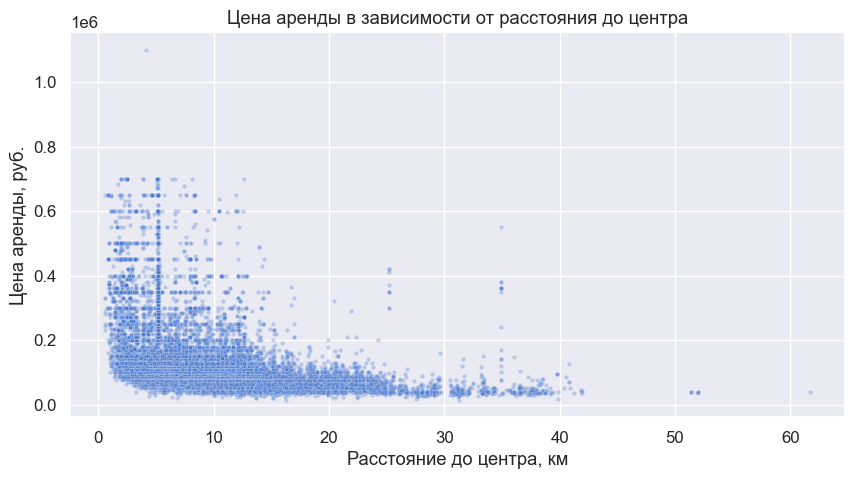

In [16]:
# Зависимость цены от расстояния до центра
plt.figure(figsize=(10, 5))
sns.scatterplot(x="dist_to_center_km", y="price_per_month", data=df, alpha=0.3, s=10)
plt.title("Цена аренды в зависимости от расстояния до центра")
plt.xlabel("Расстояние до центра, км")
plt.ylabel("Цена аренды, руб.")
plt.grid(True)
plt.show()

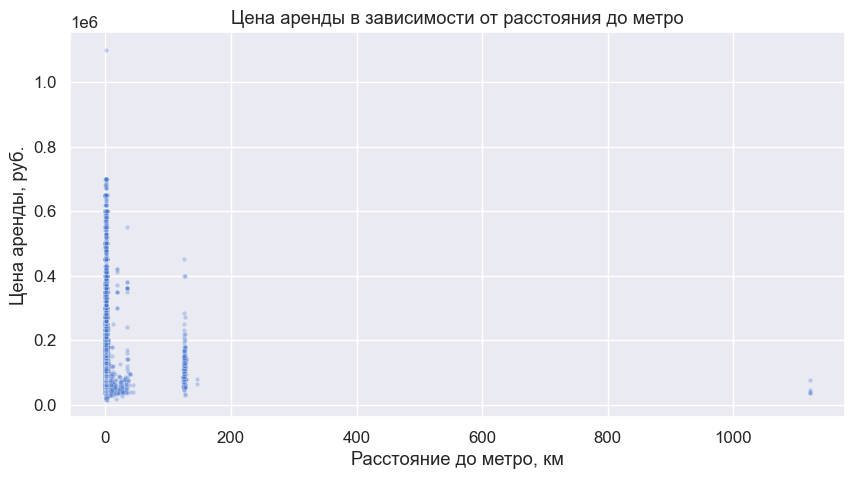

In [17]:
# Зависимость цены от расстояния до метро
plt.figure(figsize=(10, 5))
sns.scatterplot(x="dist_to_metro_km", y="price_per_month", data=df, alpha=0.3, s=10)
plt.title("Цена аренды в зависимости от расстояния до метро")
plt.xlabel("Расстояние до метро, км")
plt.ylabel("Цена аренды, руб.")
plt.grid(True)
plt.show()

In [18]:
# Удалим аномальные значения: > 100 км до метро — это точно ошибка
df = df[df["dist_to_metro_km"] < 100]

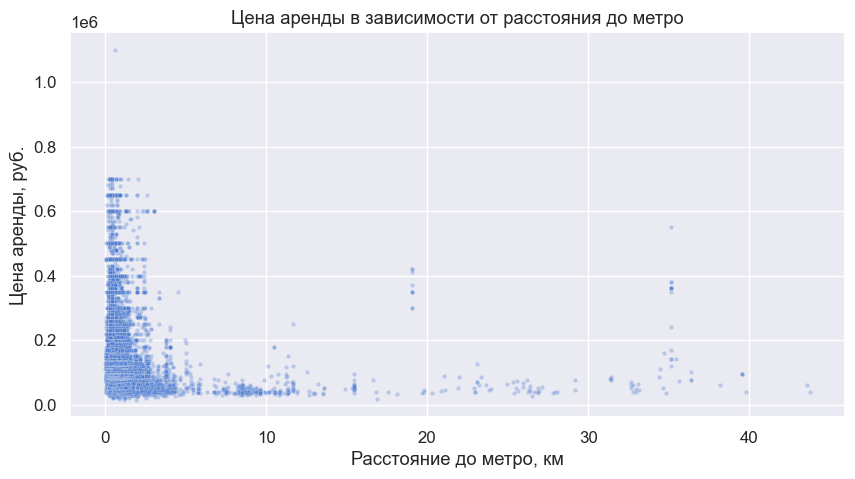

In [19]:
# Зависимость цены от расстояния до метро
plt.figure(figsize=(10, 5))
sns.scatterplot(x="dist_to_metro_km", y="price_per_month", data=df, alpha=0.3, s=10)
plt.title("Цена аренды в зависимости от расстояния до метро")
plt.xlabel("Расстояние до метро, км")
plt.ylabel("Цена аренды, руб.")
plt.grid(True)
plt.show()

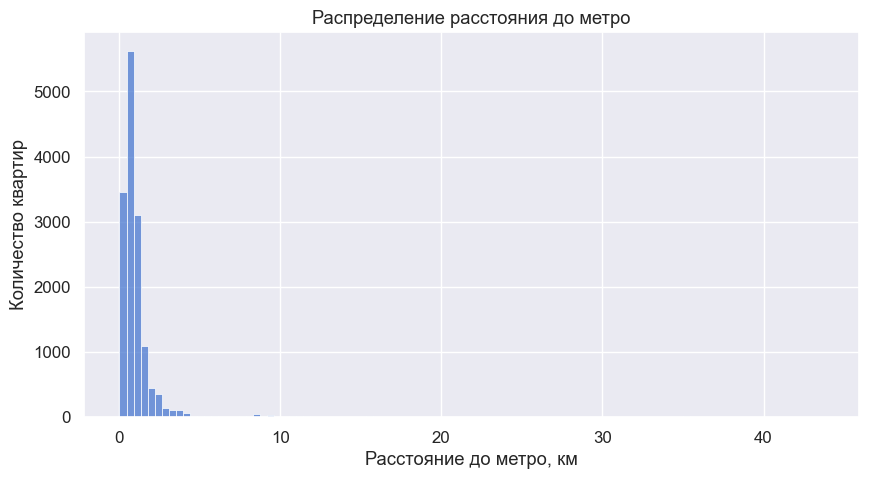

In [20]:
# Гистограмма расстояния до метро
plt.figure(figsize=(10, 5))
sns.histplot(df["dist_to_metro_km"], bins=100)
plt.title("Распределение расстояния до метро")
plt.xlabel("Расстояние до метро, км")
plt.ylabel("Количество квартир")
plt.grid(True)
plt.show()

### Выводы по `dist_to_center_km` и `dist_to_metro_km`

- Расстояние до центра Москвы (`dist_to_center_km`) распределено в пределах **0–40 км**, с пиком в районе **10 км**. Это соответствует географии старой и Новой Москвы.
- Признак показывает **чёткую обратную зависимость от цены аренды**: чем ближе к центру — тем дороже.
- Расстояние до метро (`dist_to_metro_km`) у большинства объектов составляет **менее 1 км**, что отражает хорошую транспортную доступность города.
- Обнаружены и удалены **аномалии выше 100 км** — вероятные ошибки геокодирования или отсутствие станции в радиусе. После очистки максимум составил **~40 км**.
- Оба признака адекватны, очищены от выбросов и **могут использоваться как ключевые числовые регрессоры в модели**.

___

## Доступность инфраструктуры в радиусе 1 км

Инфраструктурные признаки отражают количество объектов определённого типа в пешей доступности от квартиры. Они влияют на комфорт проживания и потенциально — на стоимость аренды.

В этом разделе мы:
- рассмотрим распределения каждого признака;
- выявим типичные значения;
- оценим, насколько часто квартиры лишены инфраструктуры вовсе;
- позже — проверим корреляцию с ценой и удалим выбросы, если потребуется.

___

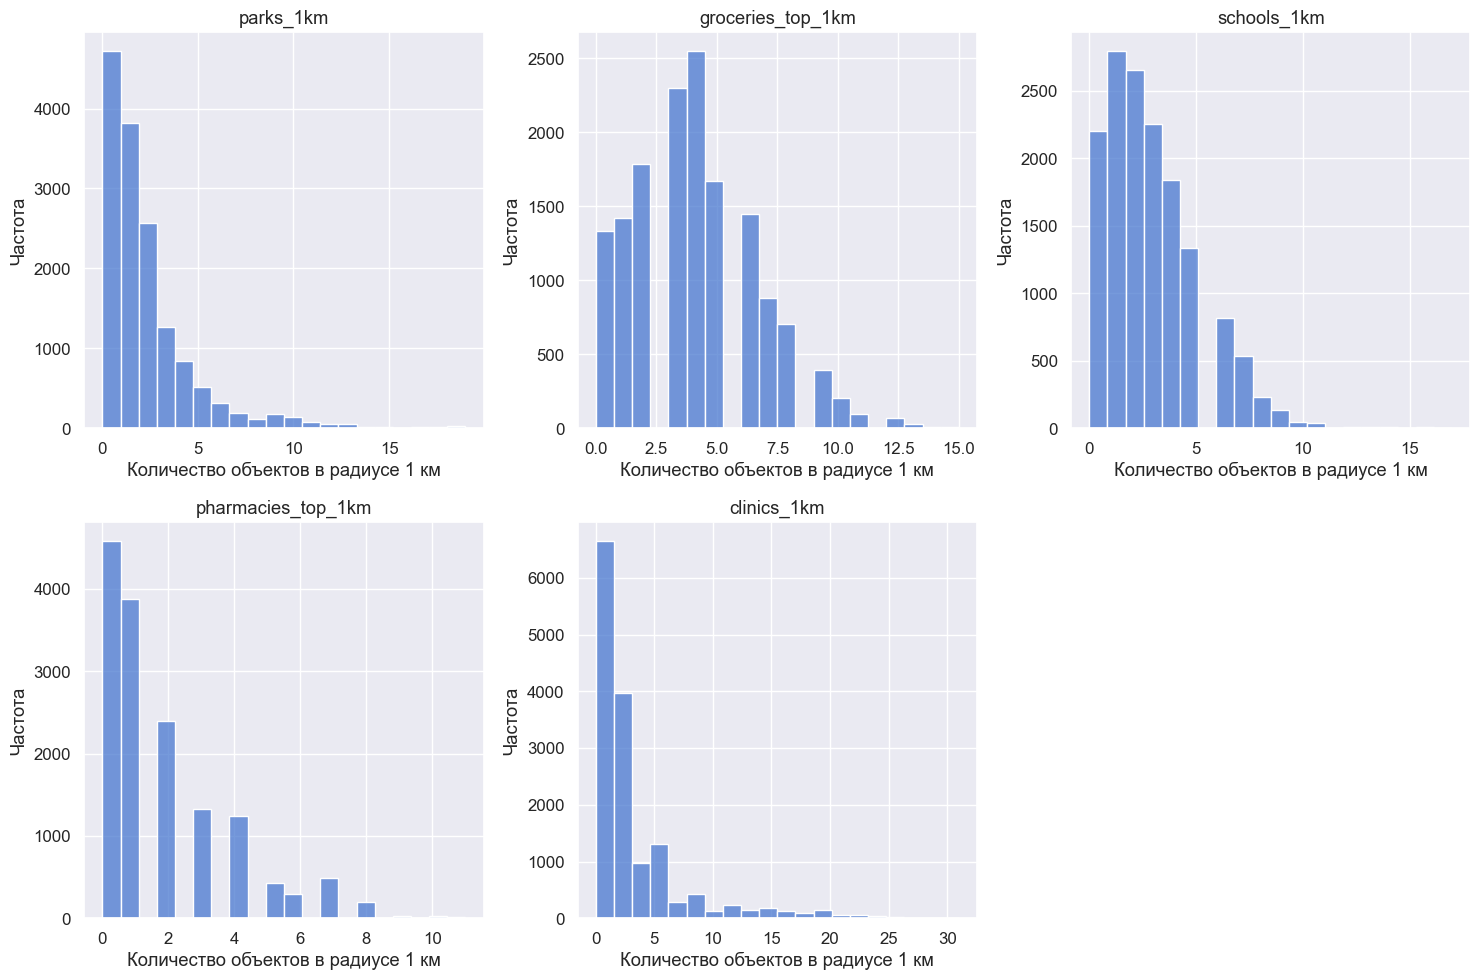

In [21]:
poi_features = [
    "parks_1km",
    "groceries_top_1km",
    "schools_1km",
    "pharmacies_top_1km",
    "clinics_1km"
]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(poi_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], bins=20)
    plt.title(f"{feature}")
    plt.xlabel("Количество объектов в радиусе 1 км")
    plt.ylabel("Частота")

plt.tight_layout()
plt.show()

### Выводы по признакам доступности объектов в радиусе 1 км

- **parks_1km**: большинство объектов имеют 0–2 парка рядом. Полное отсутствие парков встречается часто.
- **groceries_top_1km**: типичный диапазон — от 2 до 6 магазинов, пиковое значение — 4–5. Признак выглядит сбалансированно.
- **schools_1km**: основная масса квартир окружена 0–5 школами.
- **pharmacies_top_1km**: чаще всего в радиусе до 2 аптек. Распределение скошено, но адекватно.
- **clinics_1km**: почти половина объектов имеют 0–2 клиники поблизости, но в отдельных случаях — до 30. Возможные локальные кластеры (например, медицинские кварталы).

Выбросов или некорректных значений в распределениях не обнаружено. Признаки выглядят реалистично и готовы к использованию в модели.

___


## Категориальные признаки: районы и станции метро

Категориальные признаки отражают территориальную принадлежность объекта:
- Район (`district`) — может использоваться напрямую или для агрегации статистик.
- Ближайшая станция метро (`underground`) — полезна, если категориальные признаки обрабатываются корректно моделью (например, CatBoost).

Ниже представлены частоты встречаемости значений по ключевым категориям.

___

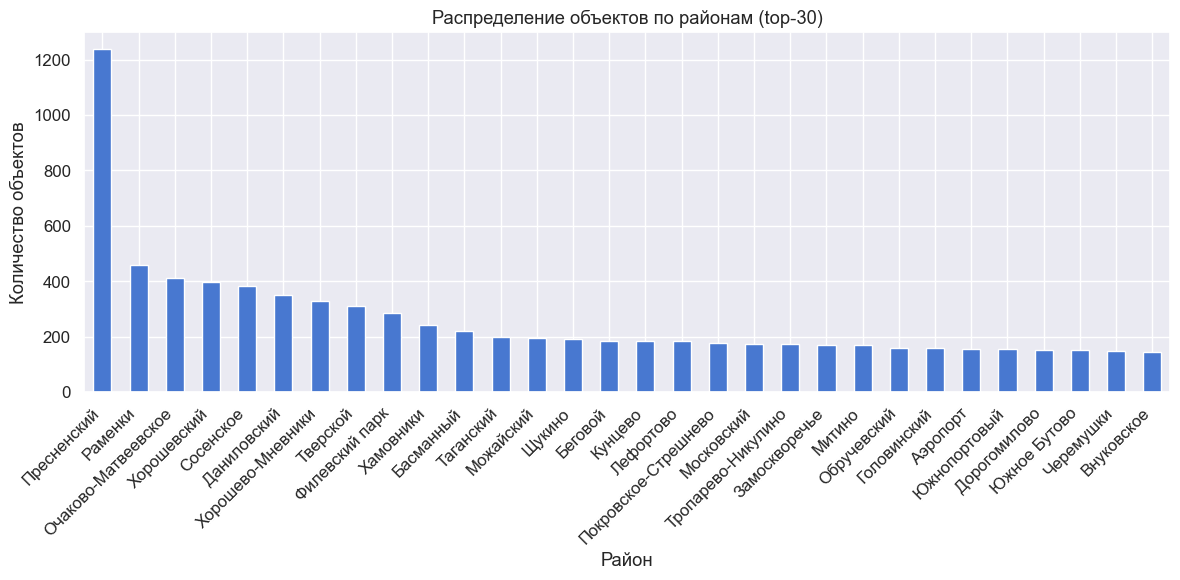

In [22]:
# Топ-30 районов по количеству объектов
plt.figure(figsize=(12, 6))
df["district"].value_counts().head(30).plot(kind="bar")
plt.title("Распределение объектов по районам (top-30)")
plt.xlabel("Район")
plt.ylabel("Количество объектов")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

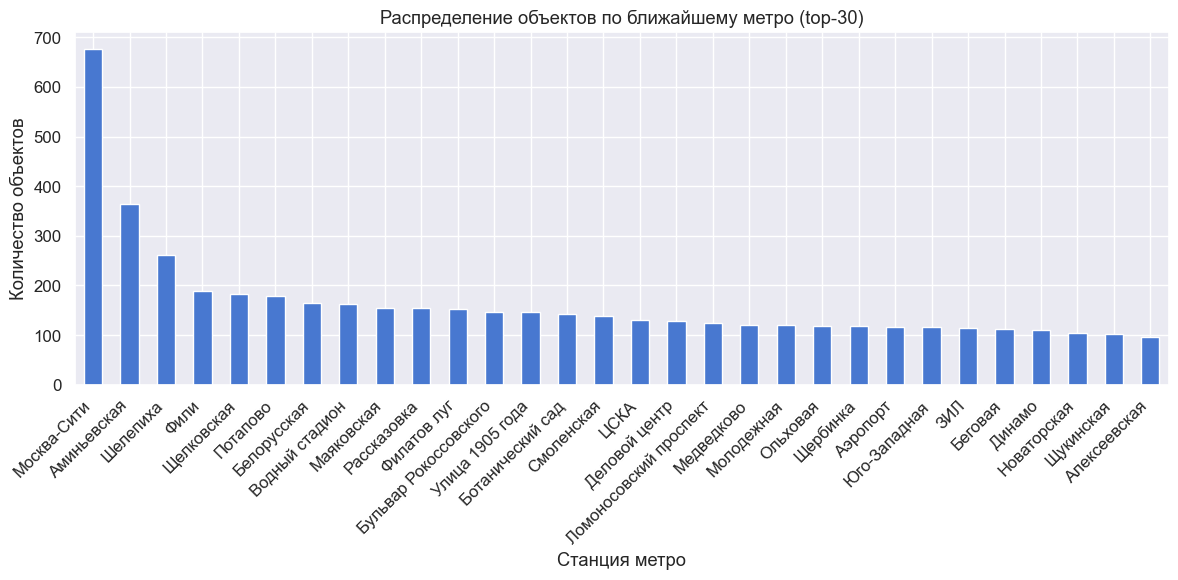

In [23]:
# Топ-30 станций метро
plt.figure(figsize=(12, 6))
df["underground"].value_counts().head(30).plot(kind="bar")
plt.title("Распределение объектов по ближайшему метро (top-30)")
plt.xlabel("Станция метро")
plt.ylabel("Количество объектов")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Финальные итоги EDA и очистки

В рамках анализа мы:

- Исследовали распределения всех ключевых признаков: цена, площадь, комнаты, этаж, удалённость, инфраструктура, районы и метро;
- Выявили и устранили аномалии: студии (`-1 → 0`), неверные координаты, выбросы в расстоянии до метро;
- Убедились в валидности признаков — распределения реалистичны, выбросы устранены, категориальные признаки готовы к кодированию;
- Инфраструктурные признаки, геопозиция и удалённость до центра/метро оказались информативными и пригодными для модели;
- Провели минимально необходимую очистку и удалили неинформативные поля.

Датасет готов к переходу к следующему этапу — построению моделей и прогнозированию стоимости аренды**.

___


In [24]:
# Сохраняем финальный очищенный датасет
df.to_csv("cian_rent_Moscow_final.csv", index=False, encoding="utf-8-sig")